In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from scipy.stats import gaussian_kde

from  datetime import date
#import statsmodels.api as sm
import pylab 
import scipy.stats as stats
today=date.today()
import math
today=(today.strftime('%Y-%m-%d'))

In [2]:
#Semilla aleatoria de numpy
np.random.seed(0)
nivelsignificatividad=0.05

#Paremtros adicionales
#Numero de días para tener en cuenta en la predicción
back=40
#Porcentaje de entrenamiento
train=0.8

In [3]:
#Librerias necesarias para las redes neuronales
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,LSTM, Input, Activation, concatenate

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History

#Semilla aleatoria de tsnsorflow
#tf.random.set_seed(0)


2023-04-27 17:11:36.976256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
#Crear dataset
filas=1000
columnas=5
datos_aleatorios = np.random.rand(filas,columnas)
data = pd.DataFrame(datos_aleatorios, columns=['Open', 'High', 'Low','Volume','Close'])


In [59]:

hist=data[:-numdias]
real=data[-numdias:]
numregressors=data.shape[1]-1
numdias=real.shape[0]

(158, 5)

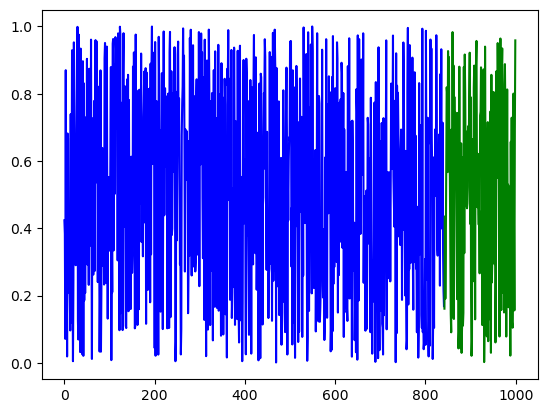

In [61]:
plt.plot(hist['Close'],c='b')
plt.plot(real['Close'],c='g')
plt.show()

In [4]:
#Funcion de resumen para el rendimiento de cada red neuronal
#Se le pasa por parametro la configuracion de la red, predicción y datos reales.Devuelve un dataframe con el calculo de estadisticos y normalidad del residuo
#Se guarda ademas para cada red el numero de epochs para el que ha minimizado al perdida porque habrá que volver a usar esta parámetro para predicción
def resumen(nummodelo,back,numregressors,epochs,neuronashidden1,neuronashidden2,neuronashidden3,y_test,y_pred,LSTM=True):
    
    n=y_pred.shape[0]
    k=numregressors
    res=(y_pred-y_test)
    #res = res[~np.isnan(res)]
    sumares=np.sum(res)
    
    res2=(y_pred-y_test)**2
    sumres2=np.sum(res2,axis=0)
    #y_pred=y_predic
    
           
#Media residuo
    mediares=res.mean()
#Desv resudio
    desvres=res.std()
#RMSE
    rmse=np.sqrt((sumres2/n))
#MEA
    mae=(1/n)*np.sum(np.abs(res))
#MAPE
    mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))

#AKAIKE
    L=(-n/2)*(1+math.log(2*math.pi)-math.log(n))-((n/2)*math.log(sumres2))
    AIC=n*(math.log(sumres2/n))+(2*k)+(n*(1+math.log(2*math.pi)))

#Davidson and MCKInnon
    DM=L-k
#BIC(Bayesian Information Criterio)
    BIC=(-2*L)+(k*math.log(n))

#Hannan and Quinn
    HQC=(-2*L)+(2*k*math.log(math.log(n)))

#bias
    bias=(1/n)*np.sum(res)
#Jarque-Bera normalidad residuo
    pvalue=stats.jarque_bera(res)[1]
###Gráfica
  

    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'black', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.legend()
    plt.show()
    
     

###Comparativa
    datoscomparativa= [{'NumModelo':nummodelo,'Dias Muestra':back,'LSTM':LSTM,'Regresores':numregressors,'Epochs':epochs,'Capa Oculta1': neuronashidden1, 'Capao Oculta2': neuronashidden2, 'CapaOculta3': neuronashidden3,'Bias':bias,'Residuo':sumares,'Media Residuo':res.mean(),'Residuo **2':round(sumres2[0],10),'P-value Jarque Bera':pvalue,'RMSE':rmse[0],'MAE':mae,'MAPE':mape,'AKAIKE':AIC,'BIC':BIC,'HQC':HQC,'DM':DM}]
    dfcomparativa=pd.DataFrame(datoscomparativa)

    return dfcomparativa

In [63]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(hist)

In [64]:
X = []
print(data_set_scaled.shape[0])
for j in range(numregressors):
    X.append([])
    for i in range(back, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back:,-1])
y=np.reshape(yi,(len(yi),1))


842


In [14]:
#Creacion primera red neuronal Modelo1 de una sola capa oculta
neuronashidden1=150
neuronashidden2=0
neuronashidden3=0

In [53]:
# Train/Test split 
splitlimit = int(len(X)*train)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Para establecer la compartiva con ARIMA lo más fiel fijamos el numero de dias de predecir en igual longitud
ndias=y_test.shape[0]

630
(630, 40, 4)
(158, 40, 4)
(630, 1)
(158, 1)


In [15]:
# Entrada y salida
lstm_input = Input(shape=(back, numregressors), name='lstm_input')
inputs = LSTM(neuronashidden1, name='HiddenLayer1',return_sequences=True)(lstm_input)
output=LSTM(1,activation='linear',name ='Output_Layer')(inputs)
model1 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
HiddenLayer1 (LSTM)          (None, 40, 150)           93000     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 93,608
Trainable params: 93,608
Non-trainable params: 0
_________________________________________________________________


2023-04-27 17:12:41.677889: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-27 17:12:41.678392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-27 17:12:41.704221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 17:12:41.704389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GT 1030 computeCapability: 6.1
coreClock: 1.468GHz coreCount: 3 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 44.76GiB/s
2023-04-27 17:12:41.704407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-27 17:12:41.705290: I tensorflow/stream_executor/platform/default/dso_

In [55]:
model1.compile(optimizer=adam, loss='mse')
model1.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
38/38 [==============================] - 3s 40ms/step - loss: 0.1574 - val_loss: 0.0792
Epoch 2/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0899 - val_loss: 0.0865
Epoch 3/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0842 - val_loss: 0.0788
Epoch 4/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0842 - val_loss: 0.0797
Epoch 5/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0853 - val_loss: 0.0799
Epoch 6/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0896 - val_loss: 0.0796
Epoch 7/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0815 - val_loss: 0.0782
Epoch 8/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0878 - val_loss: 0.0777
Epoch 9/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0878 - val_loss: 0.0816
Epoch 10/30
38/38 [==============================] - 1s 20ms/step - loss: 0.0859 - val_loss: 0.0789
Epoch 11/

<AxesSubplot:>

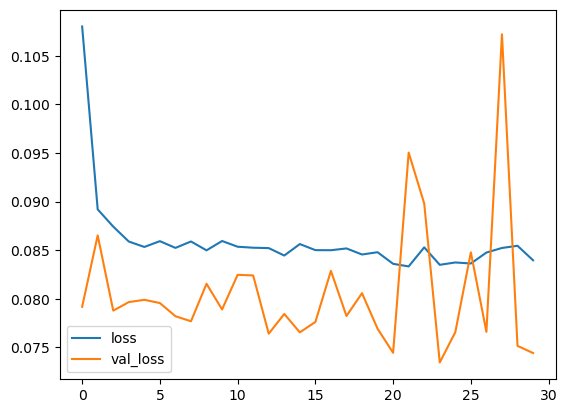

In [56]:
losses1 = pd.DataFrame(model1.history.history)
losses1.plot()

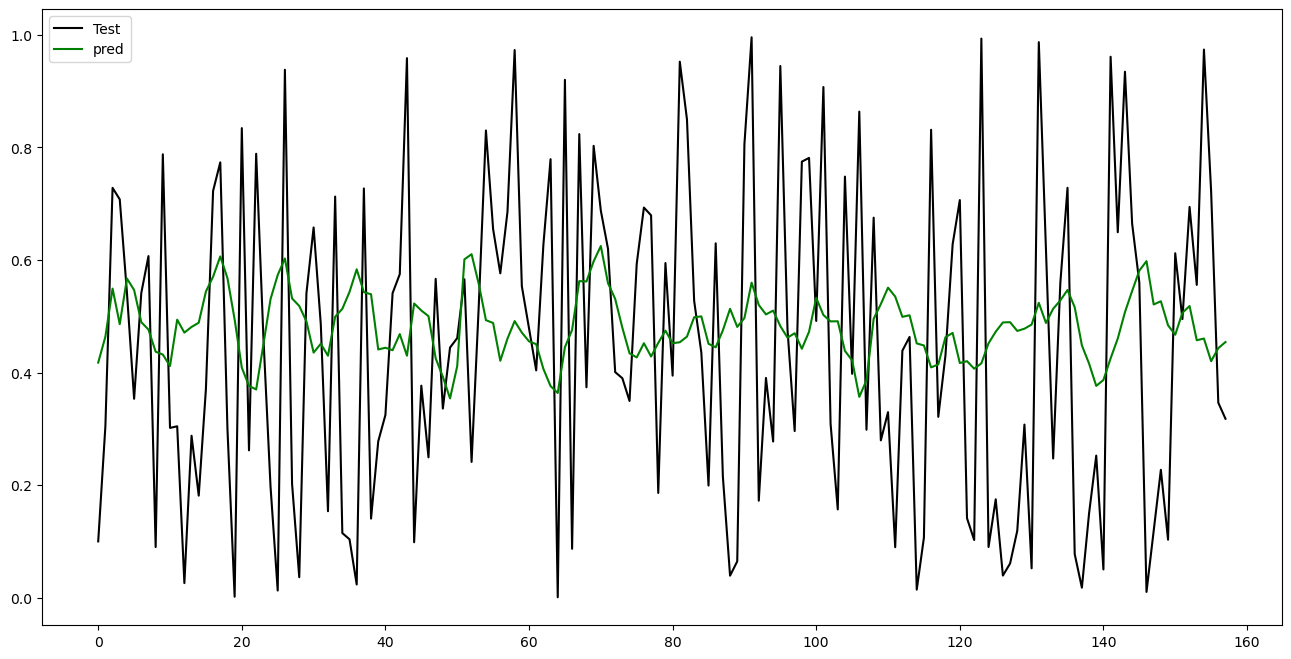

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,1,40,True,4,21,150,0,0,0.030878,4.878657,0.030878,13.518493,0.034501,0.292507,0.248973,656.882322,67.93582,80.1862,72.910853,-33.96791


In [57]:
modelo1=resumen(1,back,numregressors,losses1.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model1.predict(X_test),LSTM=True,)
modelo1

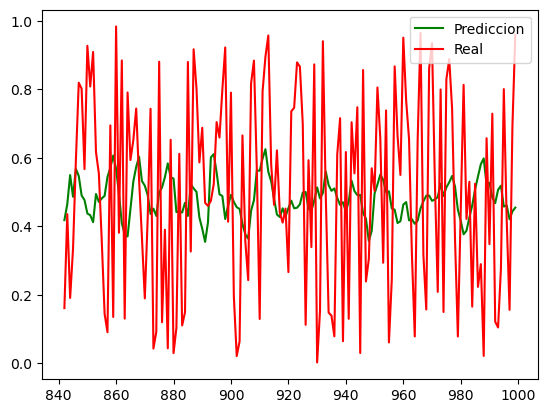

In [79]:

plt.plot(range(real['Close'].index[0],real['Close'].index[0]+real['Close'].shape[0]),model1.predict(X_test),c='g',label='Prediccion')
plt.plot(real['Close'],label='Real',c='r')
plt.legend()


In [ ]:
#Otro data set ahora con un camino aletaorio para intentar predecirlo

In [6]:
#Crear dataset con precio de cierre camino aleatorio
filas=10000
columnas=4
datos_aleatorios = np.random.rand(filas,columnas)
data = pd.DataFrame(datos_aleatorios, columns=['Open', 'High', 'Low','Volume'])
data['Close']=(np.cumsum(np.random.randn(filas)))
#data['Close']=np.diff(np.cumsum(np.random.randn(filas+1)))


In [7]:
#numdias de manera manual para una comprobación. En caso de usar mas veces convendria automatizar este parametro
#que va a se rigual al tamaño de test
numdias=1960
hist=data[:-numdias]
real=data[-numdias:]
numregressors=data.shape[1]-1


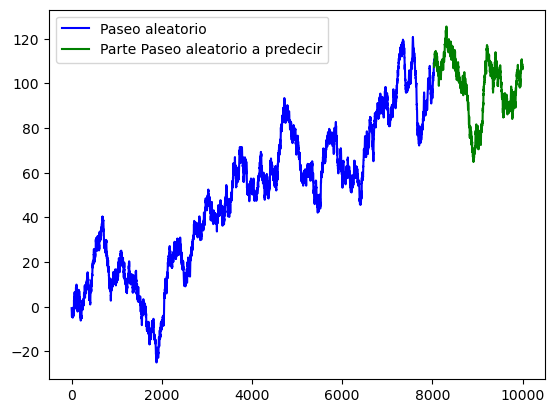

In [8]:
plt.plot(hist['Close'],c='b',label='Paseo aleatorio')
plt.plot(real['Close'],c='g',label='Parte Paseo aleatorio a predecir')
plt.legend()

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(hist)

In [10]:
X = []
print(data_set_scaled.shape[0])
for j in range(numregressors):
    X.append([])
    for i in range(back, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back:,-1])
y=np.reshape(yi,(len(yi),1))


8040


In [11]:
# Train/Test split 
splitlimit = int(len(X)*train)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Para establecer la compartiva con ARIMA lo más fiel fijamos el numero de dias de predecir en igual longitud
ndias=y_test.shape[0]

6400
(6400, 40, 4)
(1600, 40, 4)
(6400, 1)
(1600, 1)


In [16]:
model1.compile(optimizer=adam, loss='mse')
model1.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

2023-04-27 17:12:51.032368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-27 17:12:51.044600: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/30


2023-04-27 17:12:52.008567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-27 17:12:52.123706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


384/384 [==============================] - 8s 17ms/step - loss: 0.0431 - val_loss: 0.0247
Epoch 2/30
384/384 [==============================] - 7s 17ms/step - loss: 0.0346 - val_loss: 0.0321
Epoch 3/30
384/384 [==============================] - 6s 17ms/step - loss: 0.0348 - val_loss: 0.0329
Epoch 4/30
384/384 [==============================] - 7s 17ms/step - loss: 0.0354 - val_loss: 0.0331
Epoch 5/30
384/384 [==============================] - 8s 20ms/step - loss: 0.0341 - val_loss: 0.0318
Epoch 6/30
384/384 [==============================] - 7s 19ms/step - loss: 0.0348 - val_loss: 0.0278
Epoch 7/30
384/384 [==============================] - 7s 19ms/step - loss: 0.0347 - val_loss: 0.0273
Epoch 8/30
384/384 [==============================] - 9s 23ms/step - loss: 0.0346 - val_loss: 0.0322
Epoch 9/30
384/384 [==============================] - 11s 28ms/step - loss: 0.0342 - val_loss: 0.0269
Epoch 10/30
384/384 [==============================] - 11s 27ms/step - loss: 0.0346 - val_loss: 0.024

<AxesSubplot:>

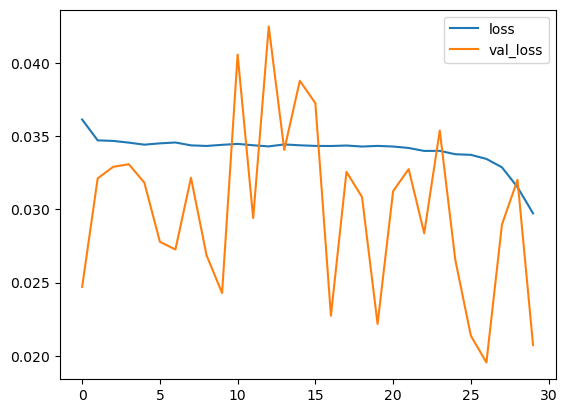

In [17]:
losses1 = pd.DataFrame(model1.history.history)
losses1.plot()

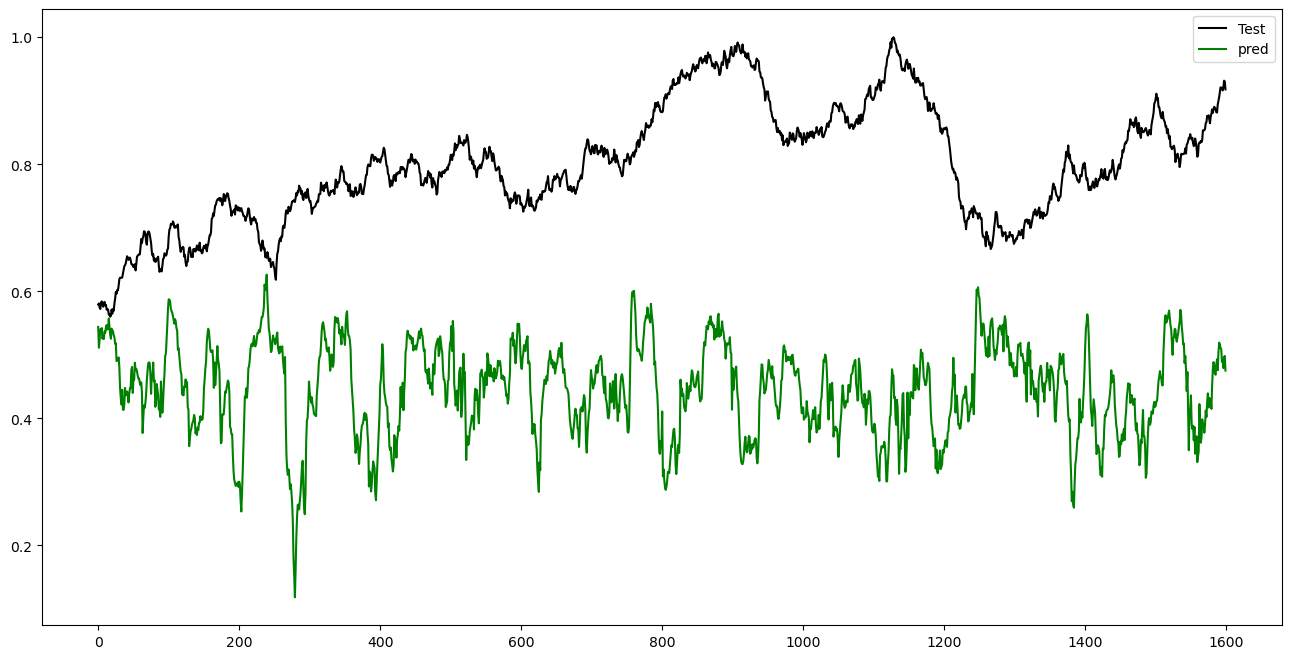

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,1,40,True,4,29,150,0,0,-0.353795,-566.072087,-0.353795,226.653516,0.001743,0.376375,0.353795,43.254411,1421.665035,1443.176071,1429.652795,-710.832518


In [18]:
modelo1=resumen(1,back,numregressors,losses1.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model1.predict(X_test),LSTM=True,)
modelo1

In [194]:
neuronashidden1=150
neuronashidden2=150
neuronashidden3=0

In [195]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model3 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model3.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           93000     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 274,208
Trainable params: 274,208
Non-trainable params: 0
_________________________________________________________________


In [196]:
model3.compile(optimizer=adam, loss='mse')
model3.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
losses3 = pd.DataFrame(model3.history.history)

Epoch 1/30
384/384 [==============================] - 8s 18ms/step - loss: 0.0517 - val_loss: 0.0901
Epoch 2/30
384/384 [==============================] - 7s 18ms/step - loss: 0.0438 - val_loss: 0.1456
Epoch 3/30
384/384 [==============================] - 7s 18ms/step - loss: 0.0493 - val_loss: 0.1058
Epoch 4/30
384/384 [==============================] - 8s 20ms/step - loss: 0.0448 - val_loss: 0.1192
Epoch 5/30
384/384 [==============================] - 7s 19ms/step - loss: 0.0440 - val_loss: 0.1235
Epoch 6/30
384/384 [==============================] - 7s 19ms/step - loss: 0.0432 - val_loss: 0.0984
Epoch 7/30
384/384 [==============================] - 8s 20ms/step - loss: 0.0416 - val_loss: 0.1053
Epoch 8/30
384/384 [==============================] - 7s 18ms/step - loss: 0.0427 - val_loss: 0.1008
Epoch 9/30
384/384 [==============================] - 8s 20ms/step - loss: 0.0408 - val_loss: 0.1063
Epoch 10/30
384/384 [==============================] - 7s 19ms/step - loss: 0.0408 - val_lo

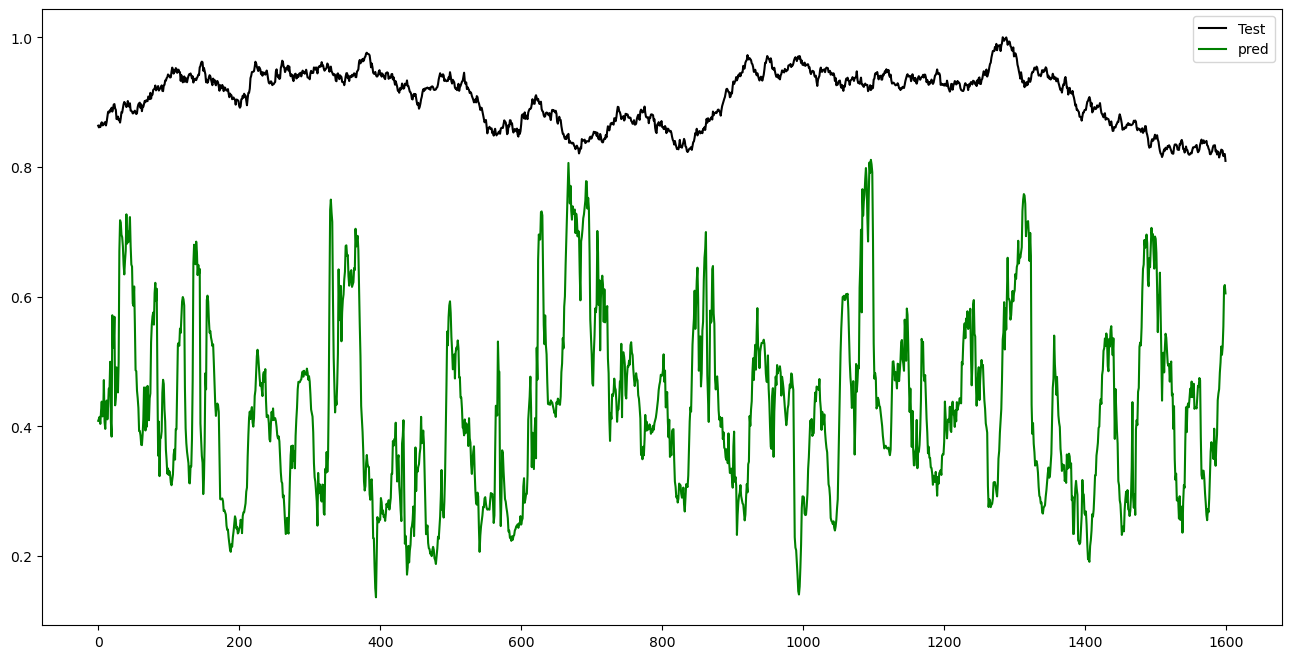

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,3,40,True,4,28,150,150,0,-0.479605,-767.367939,-0.479605,402.757551,1.110223e-16,0.501721,0.479605,52.640194,2341.524685,2363.035721,2349.512444,-1170.762342


In [197]:
modelo3=resumen(3,back,numregressors,losses3.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model3.predict(X_test),LSTM=True)
modelo3

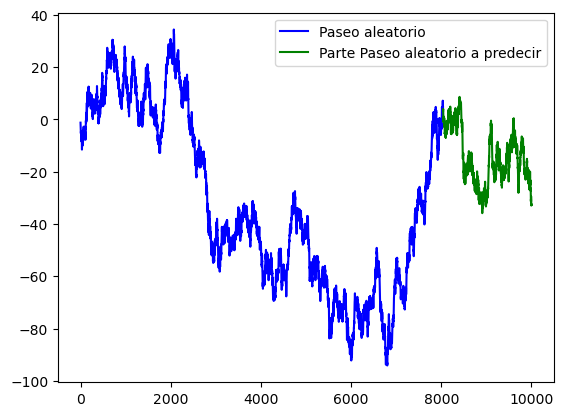

In [218]:
plt.plot(hist['Close'],c='b',label='Paseo aleatorio')
plt.plot(real['Close'],c='g',label='Parte Paseo aleatorio a predecir')
plt.legend()

In [19]:
#Para la predicción standarizo los datos reales pero con los parametros de train,asi los datos a predecir
#nunca han formado parte del dataset ni siquiera para la estandarizacion
real_scaled = sc.transform(real)

In [20]:

#Vuelvo a aplicar el mismo codigo sobre los datos reales estandarizados.
#Tiene que tener la misma dimension para la predicción
X_real = []
print(real_scaled.shape[0])
for j in range(numregressors):
    X_real.append([])
    for i in range(back, real_scaled.shape[0]):
        X_real[j].append(real_scaled[i-back:i, j])


X_real=np.moveaxis(X_real, [0], [2])


X_real, yi_real =np.array(X_real), np.array(real_scaled[back:,-1])
y_real=np.reshape(yi_real,(len(yi_real),1))


1960


In [22]:
#Se predice los datos que no han formado parte del entrenamiento
forecast=model1.predict(X_real[::,::,::])
forecast=np.array(forecast)
forecast.shape

(1920, 1)

In [23]:
aux=np.ones((forecast.shape[0],hist.shape[1]-1))
forecast=np.c_[aux,forecast]
forecastInv=sc.inverse_transform(forecast)

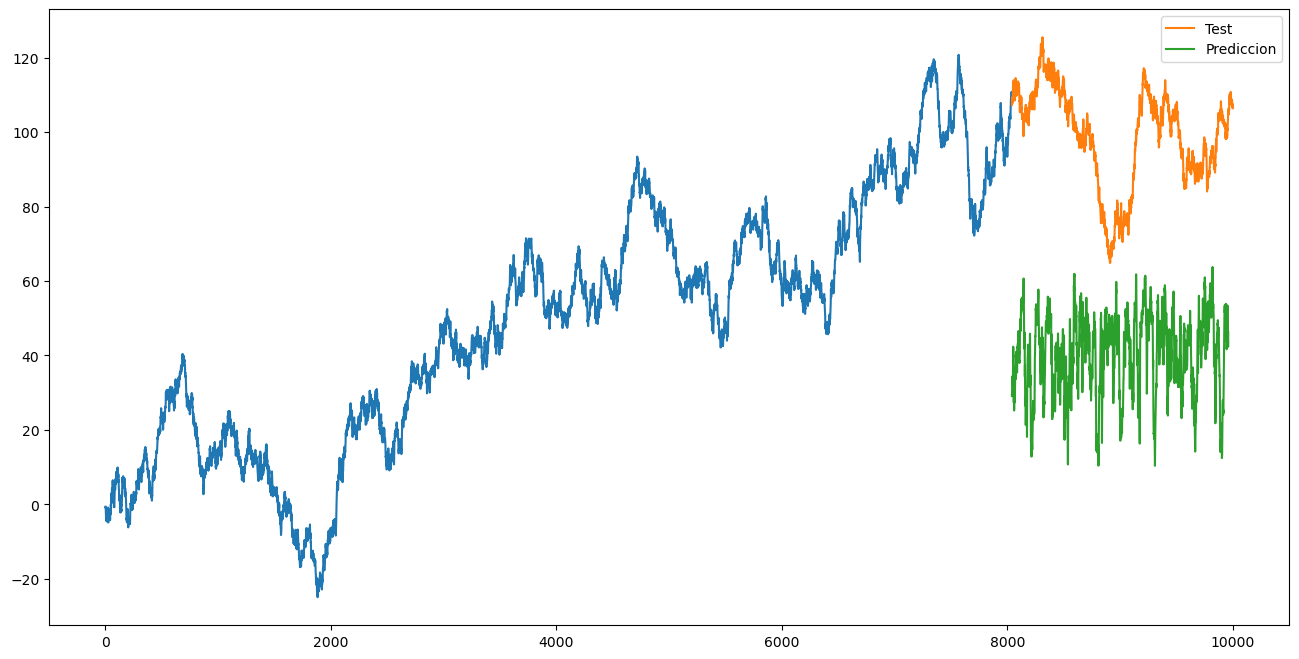

In [24]:
plt.figure(figsize=(16,8))
#plt.plot(hist['Close'],label='Hist')
#Al perderse los indices modificando los dataframes añado la cotizacion real eliminada a continuación de la 
# cotizacion real
plt.plot(hist['Close'])
plt.plot(range(hist.shape[0],hist.shape[0]+real.shape[0]),real['Close'],label='Test')
plt.plot(range(hist.shape[0],hist.shape[0]+forecastInv[::,-1].shape[0]),forecastInv[::,-1],label='Prediccion')
plt.legend()
plt.show()

In [25]:
'''
El estadístico sigue una chi cuadrado x 2 con 2 grados de libertad y sirve para contrastar
la hipótesis nula Ho de que los residuos siguen una distribución normal Ho: los residuos
estimados se distribuyen normalmente. Si el valor estimado es mayor que el de tablas para un
determinado nivel de confianza, entonces rechazamos la hipótesis nula.
'''
def jarquebera(data,sig):
    jarqueberatest=stats.jarque_bera(data)
    if jarqueberatest[1]<sig:
        print("NO Normalidad según criterio JB")
    else:
        print("Normalidad según criterio JB")

#Para omitir Nulos o Nan en jarquebera
#jarque_bera_test = stats.jarque_bera(result.resid,nan_policy='omit')


In [26]:
def residuospredic(test,predic):

    #residuos=np.array(test_data['Close']-dfpredic['Close'])
    residuos=test-predic
#Eliminar nulos NaN
    #residuos = residuos[~np.isnan(residuos)]

    mediaresiduos=residuos.mean()
    desvresiduos=np.std(residuos)
    n=residuos.shape[0]

#Histograma
    #plt.hist(residuos,bins=50,density=True)
    plt.plot(residuos,label='residuo')
    plt.figure(figsize=(4,4))
##qqplot
    residuosv2=residuos[~np.isnan(residuos)]
    stats.probplot(residuosv2,plot=plt)

#normal
    #Dependiendo de la forma es posible tener que ajustar los limites
    #x = np.linspace(-4,4,num=n)
    x = np.linspace(-8,8,num=n)

#Caso que queramos poner como limites los valores minimo y maximo respectivamente de los residuos
#x = np.linspace(int(residuos.min()),int(residuos.max()),num=n)

#Curva normal con paramatros media= media de los residuos  y varianza= varianza de los residuos 
#En caso que los datos siguiesen dirtribucion normal se tendria que parecer a esta curva 
    y = stats.norm.pdf(x, mediaresiduos, desvresiduos)

#Curva normal N(0,1)
    y2=stats.norm.pdf(x,0,1)
    fig, ax = plt.subplots(figsize=(17,4))

# Si el residuo se distribuyese normalmente sería con esta forma N(mediaresiuos,desv residuos**2)
    ax.plot(x, y,"--", linewidth=2,c='r',label='Curva normal Teorica')
    ax.plot(x, y2,"--", linewidth=2,c='g',label='N(0,1)')
#Calculo de la funcion densidad mediante método
    #residuos.plot.kde(bw_method=0.3,label='Funcion Densidad residuos mediante kde')

#Implemantación manual de la función de densidad de los residuos
    densidadresiduos=gaussian_kde(residuosv2)
    densidadresiduos._compute_covariance()
    ax.plot(x,densidadresiduos(x),label="Residuos")

    #ax.hist(x=residuos, density=True, bins=30, color="#3182bd", alpha=0.5,label='Histograma residuos')
    ax.hist(x=residuos, density=True, bins=30,  alpha=0.5,label='Histograma residuos')
    ax.set_title('Distribución de Errores')
    ax.set_xlabel('Error')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    plt.legend()
    plt.show()
    
    #jarquebera(residuos,nivelsignificatividad)

    return jarquebera(residuos,nivelsignificatividad)

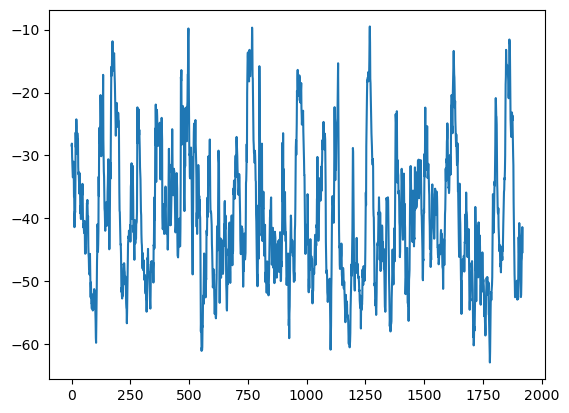

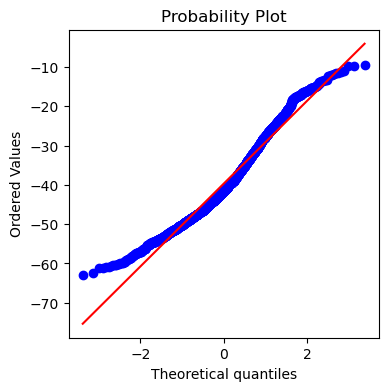

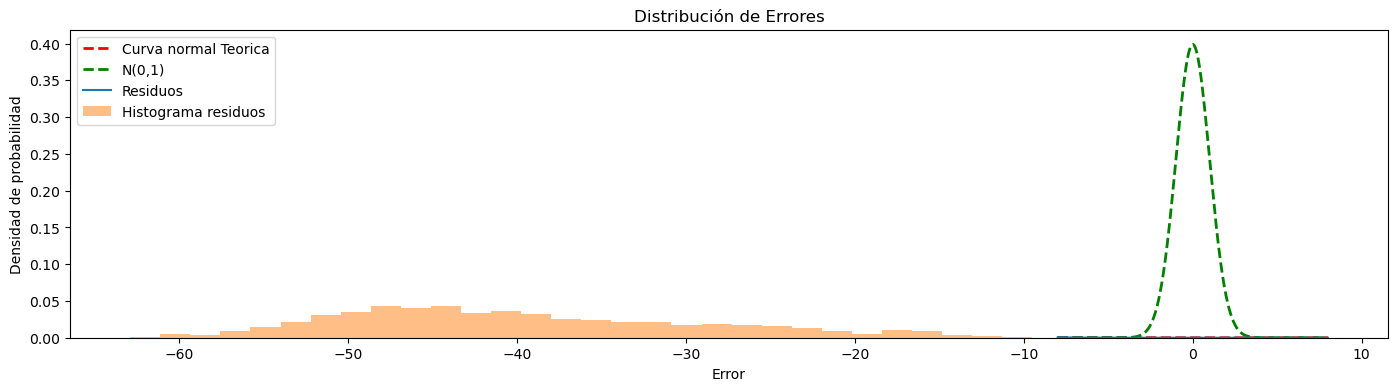

NO Normalidad según criterio JB


In [27]:
residuospredic(y_real,forecastInv[::,-1].reshape(-1,1))

In [143]:
forecastInv[::,-1].reshape(-1,1)
forecastInv.shape

(121, 5)

numpy.ndarray

In [171]:
neuronashidden1=150
neuronashidden2=150
neuronashidden3=150

In [183]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden3, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model3 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model3.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           93000     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 0)             0         
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 8         
Total params: 273,608
Trainable params: 273,608
Non-trainable params: 0
_________________________________________________________________


In [184]:
model3.compile(optimizer=adam, loss='mse')
model3.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
losses3 = pd.DataFrame(model3.history.history)

Epoch 1/30


2023-04-27 11:44:51.031599: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at cudnn_rnn_ops.cc:1514 : Unknown: CUDNN_STATUS_BAD_PARAM
in tensorflow/stream_executor/cuda/cuda_dnn.cc(1147): 'cudnnSetRNNDescriptor_v6( cudnn.handle(), rnn_desc.get(), hidden_size, num_layers, dropout_desc.handle(), input_mode, direction_mode, rnn_mode, rnn_algo, compute_type)'


UnknownError:    CUDNN_STATUS_BAD_PARAM
in tensorflow/stream_executor/cuda/cuda_dnn.cc(1147): 'cudnnSetRNNDescriptor_v6( cudnn.handle(), rnn_desc.get(), hidden_size, num_layers, dropout_desc.handle(), input_mode, direction_mode, rnn_mode, rnn_algo, compute_type)'
	 [[{{node CudnnRNN}}]]
	 [[model_6/Hidden3/PartitionedCall]] [Op:__inference_train_function_81628]

Function call stack:
train_function -> train_function -> train_function


/tmp/ipykernel_2964/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


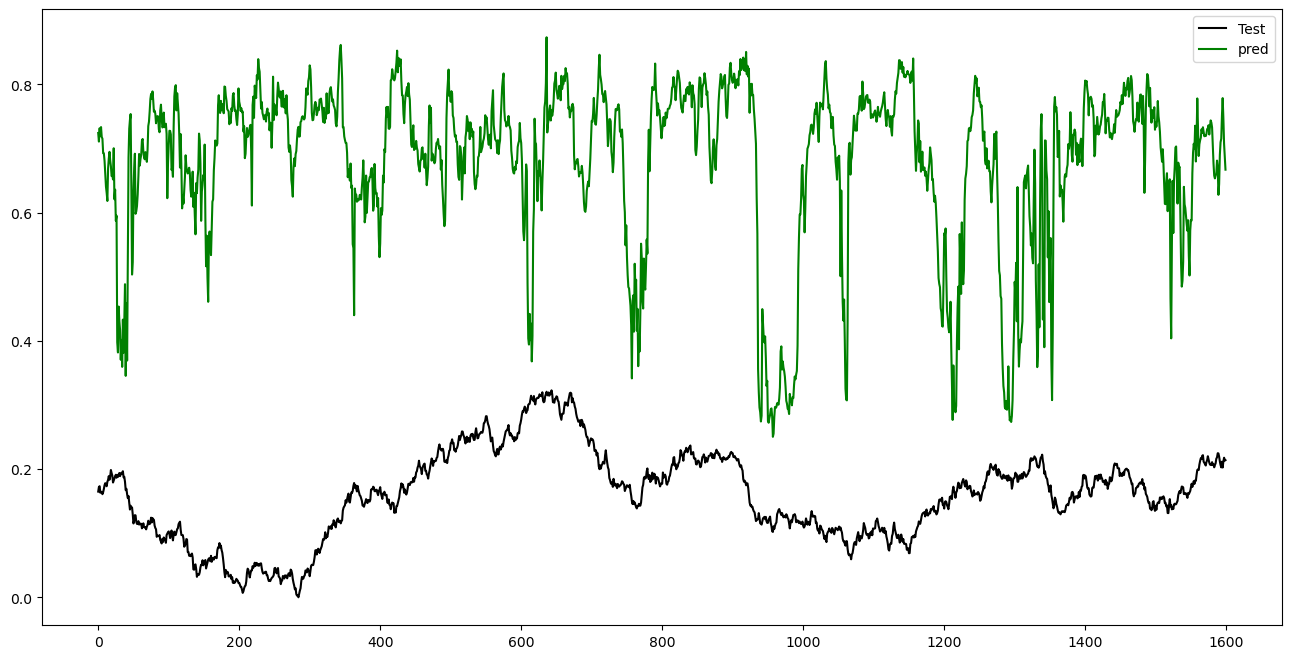

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,3,40,True,4,29,150,150,0,0.519867,831.787077,0.519867,466.646163,0.0,0.54005,0.519867,inf,2577.103117,2598.614153,2585.090876,-1288.551558


In [174]:
modelo3=resumen(3,back,numregressors,losses3.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model3.predict(X_test),LSTM=True)
modelo3

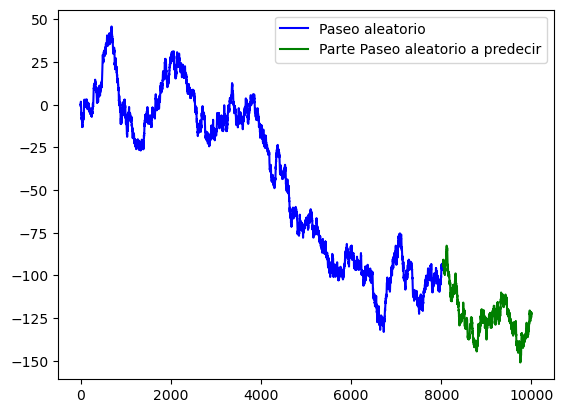

In [175]:
plt.plot(hist['Close'],c='b',label='Paseo aleatorio')
plt.plot(real['Close'],c='g',label='Parte Paseo aleatorio a predecir')
plt.legend()

In [176]:
#Para la predicción standarizo los datos reales pero con los parametros de train,asi los datos a predecir
#nunca han formado parte del dataset ni siquiera para la estandarizacion
real_scaled = sc.transform(real)

In [177]:

#Vuelvo a aplicar el mismo codigo sobre los datos reales estandarizados.
#Tiene que tener la misma dimension para la predicción
X_real = []
print(real_scaled.shape[0])
for j in range(numregressors):
    X_real.append([])
    for i in range(back, real_scaled.shape[0]):
        X_real[j].append(real_scaled[i-back:i, j])


X_real=np.moveaxis(X_real, [0], [2])


X_real, yi_real =np.array(X_real), np.array(real_scaled[back:,-1])
y_real=np.reshape(yi_real,(len(yi_real),1))


1960


In [178]:
#Se predice los datos que no han formado parte del entrenamiento
forecast=model3.predict(X_real[::,::,::])
forecast=np.array(forecast)
forecast.shape

(1920, 1)

In [179]:
aux=np.ones((forecast.shape[0],hist.shape[1]-1))
forecast=np.c_[aux,forecast]
forecastInv=sc.inverse_transform(forecast)

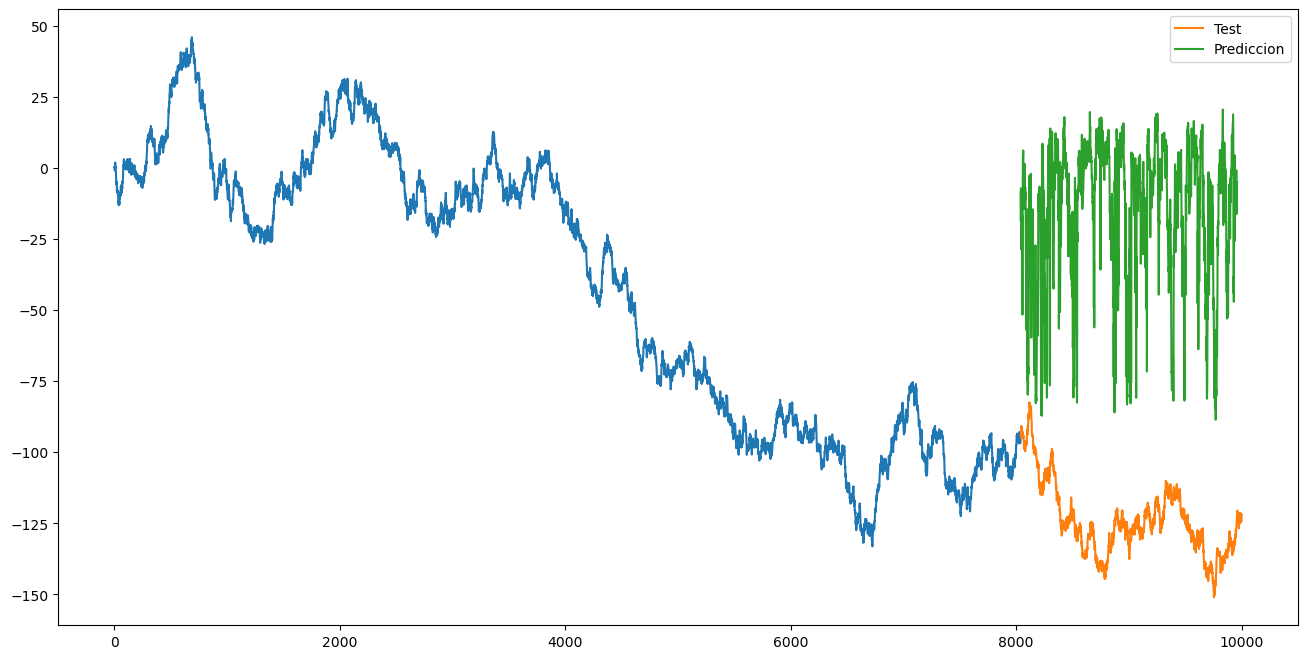

In [180]:
plt.figure(figsize=(16,8))
#plt.plot(hist['Close'],label='Hist')
#Al perderse los indices modificando los dataframes añado la cotizacion real eliminada a continuación de la 
# cotizacion real
plt.plot(hist['Close'])
plt.plot(range(hist.shape[0],hist.shape[0]+real.shape[0]),real['Close'],label='Test')
plt.plot(range(hist.shape[0],hist.shape[0]+forecastInv[::,-1].shape[0]),forecastInv[::,-1],label='Prediccion')
plt.legend()
plt.show()